In [76]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

#point-based estimate
from scipy.optimize import curve_fit
from scipy.integrate import odeint

#interval-based estimate
import pystan
import arviz as az

from sklearn.metrics import r2_score

#animation
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython import display
plt.rcParams['animation.ffmpeg_path'] = 'utils/ffmpeg'

In [78]:
df_res = pd.read_csv('datasets/analysis/responses.csv')
df_ind = pd.read_csv('datasets/analysis/inducers.csv')

In [79]:
def hill_activation(x, K, n, ymin, ymax):
    return ymin + (ymax - ymin) * (x**n / (K**n + x**n))

<ipython-input-6-caec7a488776>:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.loglog()
<ipython-input-6-caec7a488776>:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.scatter(x, y)


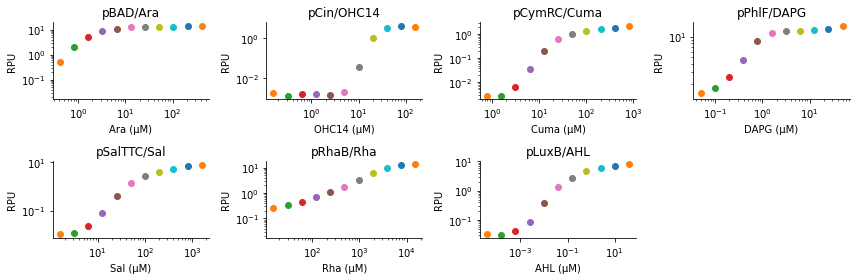

In [6]:
def promoters_combined_plots(row, col, data, inducers):
    
    ind_names = ['Ara', 'OHC14', 'Cuma', 'DAPG', 'Sal', 'Rha', 'AHL']
    cols = data.columns.tolist()
    f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*3, row*2))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(cols):
            for x, y in zip(inducers[cols[i]], data[cols[i]]):
                ax.scatter(x, y)
                ax.loglog()
            ax.set_title('{}'.format(cols[i]))
            ax.set_ylabel('RPU')
            ax.set_xlabel('{} ({})'.format(ind_names[i], u"\u03bcM"))
        else:
            ax.set_visible(False)
    sns.despine()
    plt.tight_layout()
                         
promoters_combined_plots(2, 4, df_res, df_ind)

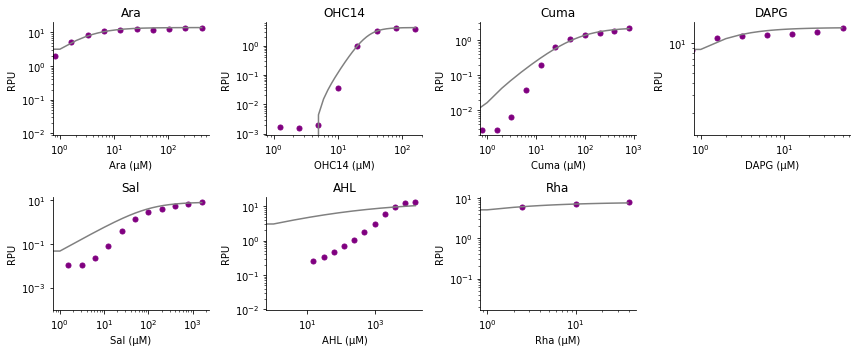

In [44]:
#ind_names = ['Ara', 'OHC14', 'Cuma', 'DAPG', 'Sal', 'AHL', 'Rha']
f, axs = plt.subplots(2, 4, sharex=False, sharey=False, figsize=(12, 5))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(ind_names):
        y = np.array(df_res.iloc[:, i])
        x = np.array(df_ind.iloc[:, i])
        init_guess = [10, 1, y.min(), y.max()]
        gate_bounds = [[0, 0, y.min()-0.01, y.max()-0.01],
                       [100, 5, y.min()+0.01, y.max()+0.01]]
        
        popt, pcov = curve_fit(hill_activation, x, y, p0=init_guess, bounds=gate_bounds)
        #print(promoters[i], popt)
        ax.scatter(x, y, color='purple', s=25)
        ax.plot(np.arange(x[-1]), hill_activation(np.arange(x[-1]), *popt), color='gray')
        ax.loglog()
        
        ax.set_title('{}'.format(ind_names[i]))
        #ax.set_xticks(np.arange(12))
        #ax.set_xticklabels([np.round(u, 2) for u in inducers[i]], rotation=45)
        ax.set_ylabel('RPU')
        ax.set_xlabel('{} ({})'.format(ind_names[i], u"\u03bcM"))
        #ax.legend()
    else:
        ax.set_visible(False)
    sns.despine()
plt.tight_layout()

In [20]:
def plot_trace(params, param_name='parameter', num_cols=2):
    
    num_rows = int(len(params)/num_cols)
    f, ax = plt.subplots(num_rows, num_cols*2, figsize=(7*num_cols, 2*num_rows))
    
    for i in tqdm(range(num_rows)):
        for j in range(num_cols):
            
            param = params[i*num_cols+j]
        
            mean = np.mean(param)
            median = np.median(param)
            cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

            ax[i, j*2].plot(param)
            ax[i, j*2].axhline(mean, color='r', lw=2, linestyle='--')
            ax[i, j*2].axhline(median, color='c', lw=2, linestyle='--')
            ax[i, j*2].axhline(cred_min, linestyle=':', color='k')
            ax[i, j*2].axhline(cred_max, linestyle=':', color='k')

            ax[i, j*2+1].hist(param, 30, density=True);
            sns.kdeplot(param, shade=True, ax=ax[i, j*2+1])
            ax[i, j*2+1].axvline(mean, color='r', lw=2, linestyle='--',label='mean')
            ax[i, j*2+1].axvline(median, color='c', lw=2, linestyle='--',label='median')
            ax[i, j*2+1].axvline(cred_min, linestyle=':', color='k', label='95% CI')
            ax[i, j*2+1].axvline(cred_max, linestyle=':', color='k')
            ax[i, j*2+1].set_ylabel(None)
            ax[i, j*2+1].legend()
    
    plt.suptitle(param_name)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

In [81]:
df_res.columns.tolist()

['pBAD-Ara',
 'pCin-OHC14',
 'pCymRC-Cuma',
 'pPhlF-DAPG',
 'pSalTTC-Sal',
 'pRhaB-Rha',
 'pLuxB-AHL']

In [184]:
col = 'pRhaB-Rha'
loaded = az.from_netcdf('datasets/analysis/resp-10000/{}.nc'.format(col))
K = np.array(loaded['posterior']['K'])
n = np.array(loaded['posterior']['n'])
ymin = np.array(loaded['posterior']['ymin'])
ymax = np.array(loaded['posterior']['ymax'])

100%|██████████| 5/5 [00:01<00:00,  4.42it/s]


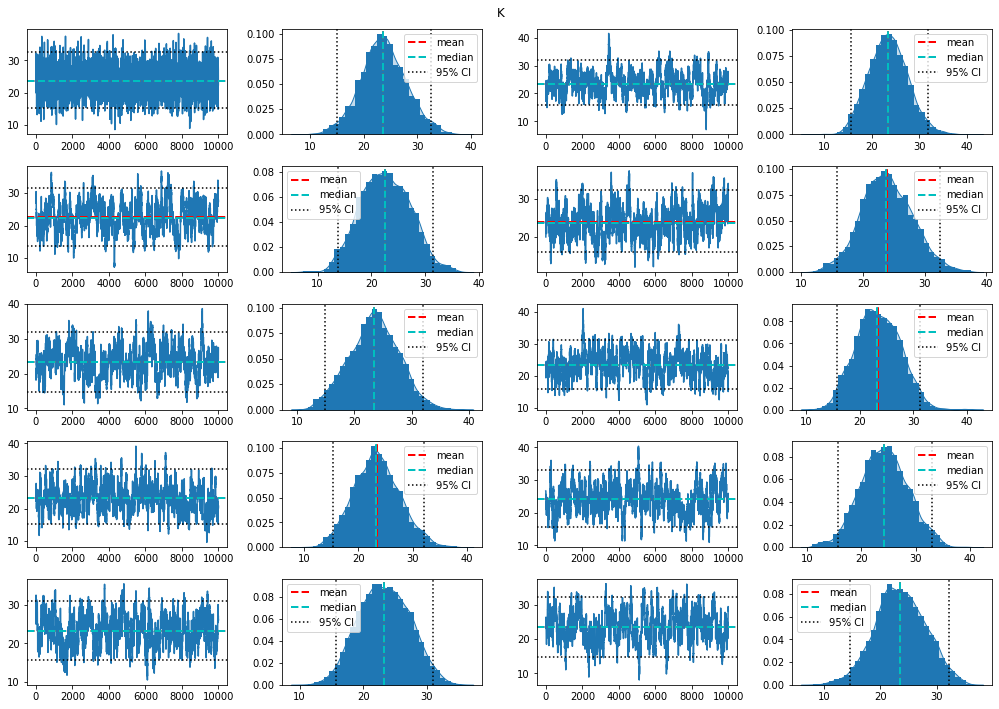

In [185]:
plot_trace(K, 'K')

100%|██████████| 5/5 [00:01<00:00,  4.91it/s]


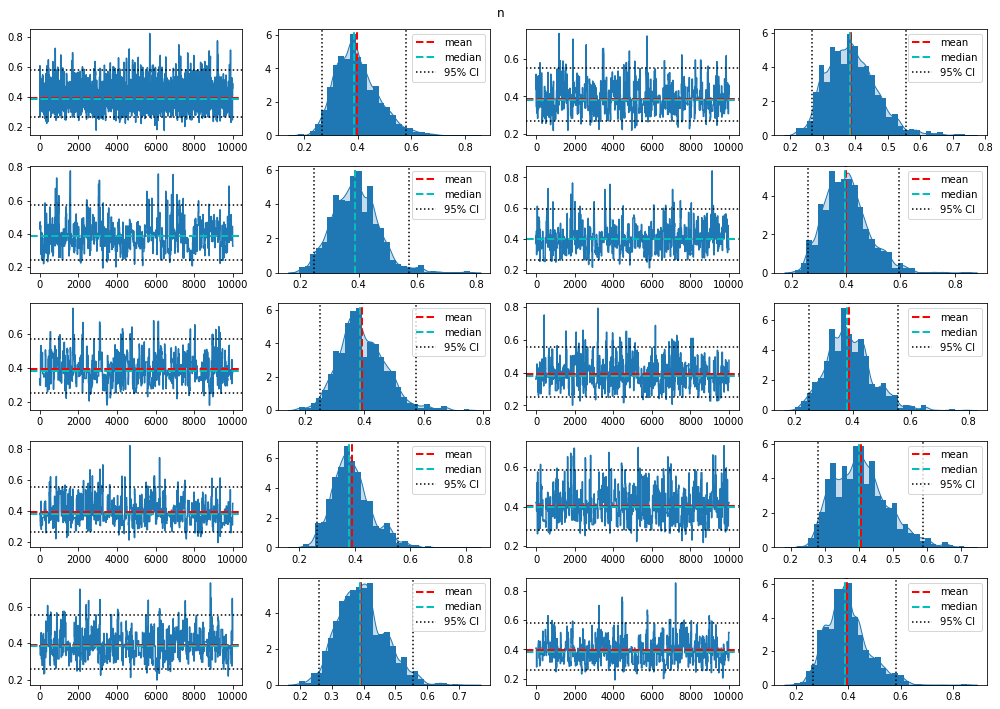

In [186]:
plot_trace(n, 'n')

100%|██████████| 5/5 [00:01<00:00,  4.81it/s]


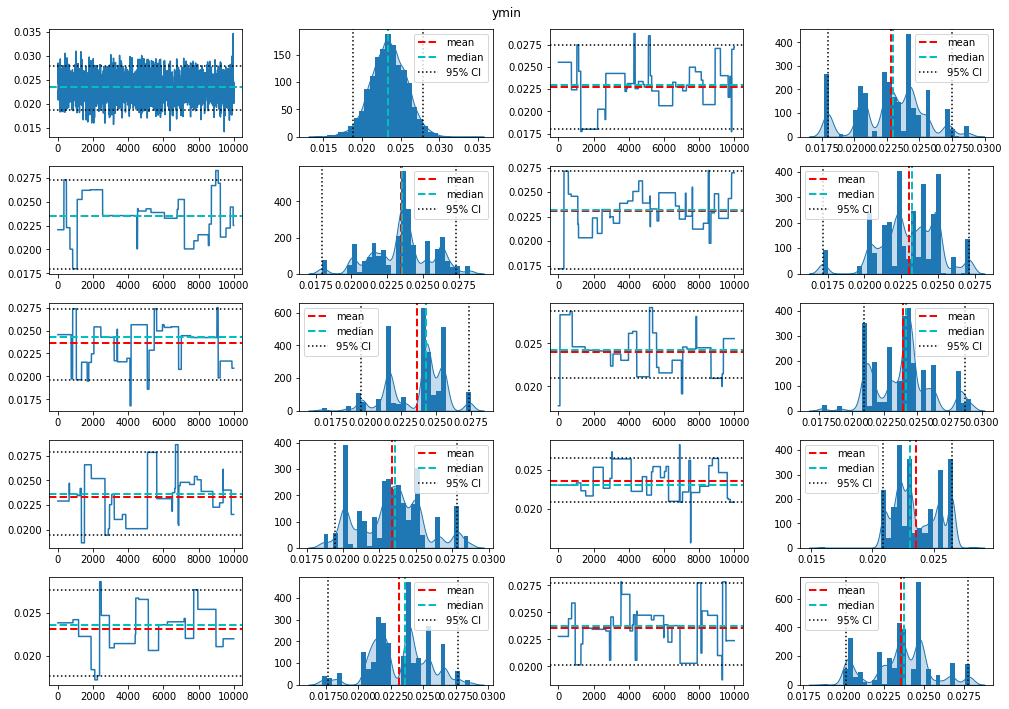

In [187]:
plot_trace(ymin, 'ymin')

100%|██████████| 5/5 [00:00<00:00,  5.18it/s]


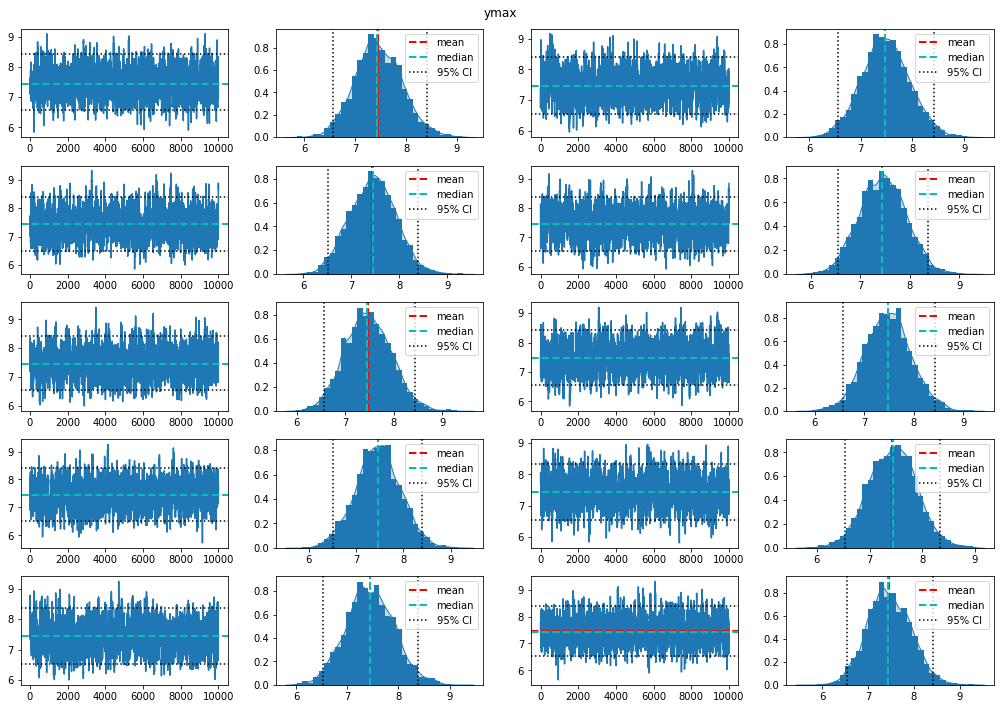

In [188]:
plot_trace(ymax, 'ymax')

In [191]:
#chain = 0
error = []
for chain in tqdm(range(10)):
    for idx in range(10000):
        popt = [K[chain][idx], n[chain][idx], ymin[chain][idx], ymax[chain][idx]]
        pred = hill_activation(df_ind[col], *popt)
        error.append(np.sum((df_res[col] - pred)**2))

100%|██████████| 10/10 [02:38<00:00, 15.80s/it]


In [192]:
dapg = np.array(error).reshape(10, 10000)
for i in range(10):
    print(i, np.min(dapg[i]))

0 167.0721439176907
1 166.58564124165747
2 167.63948752440314
3 167.88233563160296
4 166.21196784557623
5 165.0779045637296
6 167.41130922501034
7 164.936132509578
8 168.96898123550562
9 168.26241111827682


In [193]:
min_error = dapg[7].tolist().index(np.min(dapg[7]))
min_error

5077

pRhaB-Rha [22.819798775171645, 0.3766086642859379, 0.02298265158943223, 7.497518831021921]


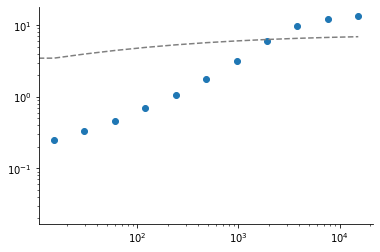

In [195]:
chain, idx = 0, 5077
popt = [K[chain][idx], n[chain][idx], ymin[chain][idx], ymax[chain][idx]]
print(col, popt)
plt.scatter(df_ind[col], df_res[col])
plt.plot(df_ind[col], hill_activation(df_ind[col], *popt), color='gray', linestyle='--')
#plt.scatter(fluo.index/60, fluo, color='gray', label='data', s=10)
plt.loglog()
#plt.legend()
sns.despine()

ara: 0, 9228, [2.214954907023476, 1.5831100491770833, 0.024326008944639297, 12.962115650664156]
ohc14: 0, 1079, [25.83525608069784, 4.0805153485479835, 0.0014252660748022299, 3.8683315811281993]
cuma: 0, 5302, [24.639673086775872, 3.744827869220542, 0.0024930475754170005, 1.6616369580888999]

dapg: 1, 4085, [0.6297864470166835, 1.8369611024650963, 1.3453158212495218, 13.034221155622838]
sal: 0, 7637, [30.529214737913925, 3.3730744526198855, 0.006655304158156326, 5.347953360601794]
rha: 0, 324, [37.4855664054021, 0.5556760906055404, 0.022429535743538006, 7.100538239587835]
ahl: 0, 179, [0.4540024132112613, 0.7065122256324078, 0.02804863029687999, 7.928798774213121]

In [177]:
cumas = [0, 6.25, 12.5, 25, 50, 100]
aras = [0, 0.8125, 3.25, 13, 52, 208]
cumas_rpu = [hill_activation(c, 24.639673086775872, 3.744827869220542, 0.0024930475754170005, 1.6616369580888999) for c in cumas]
aras_rpu = [hill_activation(a, 2.214954907023476, 1.5831100491770833, 0.024326008944639297, 12.962115650664156) for a in aras]

In [178]:
cumas_rpu, aras_rpu

([0.0024930475754170005,
  0.012183419457922659,
  0.12362677605742128,
  0.8546102179257526,
  1.5521602964092271,
  1.652939765595156],
 [0.024326008944639297,
  2.2200495754596083,
  8.398392174929793,
  12.221625319031114,
  12.8752073213337,
  12.952376203722466])

In [208]:
gates = ['e11x32STPhoRadA', 'e15x32NpuSspS2', 'e16x33NrdA2', 'e20x32gp411', 'e32x30SspGyrB',
         'e34x30MjaKlbA', 'e38x32gp418', 'e41x32NrdJ1', 'e42x32STIMPDH1']

In [271]:
gate = 'e15x32NpuSspS2'
loaded = az.from_netcdf('datasets/analysis/hill-5000/hill-{}.nc'.format(gate))
K1 = np.array(loaded['posterior']['K1'])
n1 = np.array(loaded['posterior']['n1'])
K2 = np.array(loaded['posterior']['K2'])
n2 = np.array(loaded['posterior']['n2'])
ymin1 = np.array(loaded['posterior']['ymin1'])
ymax1 = np.array(loaded['posterior']['ymax1'])
ymin2 = np.array(loaded['posterior']['ymin2'])
ymax2 = np.array(loaded['posterior']['ymax2'])

In [272]:
def hill_activation_and(x, K1, K2, n1, n2, ymin1, ymin2, ymax1, ymax2):
    
    x1, x2 = x
    return hill_activation(x1, K1, n1, ymin1, ymax1) * hill_activation(x2, K2, n2, ymin2, ymax2)

cumas_rpu = [0.0024930475754170005, 0.012183419457922659, 0.12362677605742128, 0.8546102179257526, 1.5521602964092271, 1.652939765595156],
aras_rpu = [0.024326008944639297, 2.2200495754596083, 8.398392174929793, 12.221625319031114, 12.8752073213337, 12.952376203722466]
x1, x2 = np.meshgrid(cumas_rpu, aras_rpu)
x = np.vstack((x1.ravel(), x2.ravel()))

fluos = pd.read_csv('datasets/and_gate_rpus_600.csv')
fluo = fluos[fluos['gate'].str.startswith(gate)]
y = fluo['fluo'].values

In [273]:
error = []
for chain in tqdm(range(10)):
    for idx in range(5000):
        popt = [K1[chain][idx], K2[chain][idx], n1[chain][idx], n2[chain][idx],
                ymin1[chain][idx], ymin2[chain][idx], ymax1[chain][idx], ymax2[chain][idx]]
        pred = hill_activation_and(x, *popt)
        error.append(np.sum((y - pred)**2))

100%|██████████| 10/10 [00:02<00:00,  3.92it/s]


In [274]:
indiv = np.array(error).reshape(10, 5000)
for i in range(10):
    print(i, np.min(indiv[i]))

0 0.9407884499114415
1 0.8880272663841631
2 1.0796911653046817
3 1.285002561321559
4 0.9603834466502807
5 1.152579815105079
6 1.173872273447321
7 1.008498398273614
8 1.120684575330991
9 1.0485015291708153


In [277]:
min_error = indiv[0].tolist().index(np.min(indiv[0]))
min_error

2034

e15x32NpuSspS2 [134.05411924412445, 9.475975542178588, 3.510539006880662, 4.596996782384229, 0.27391635540659154, 0.02255235541964218, 1.2440553047348297, 1.3193442842850363]
0.4369715911161276


/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


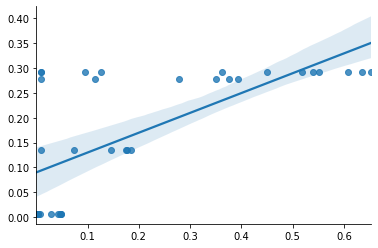

In [278]:
from sklearn.metrics import r2_score
chain, idx = 0, 2034
popt = [K1[chain][idx], K2[chain][idx], n1[chain][idx], n2[chain][idx],
                ymin1[chain][idx], ymin2[chain][idx], ymax1[chain][idx], ymax2[chain][idx]]
print(gate, popt)
sns.regplot(y, hill_activation_and(x, *popt))
print(r2_score(y, hill_activation_and(x, *popt)))
sns.despine()

In [ ]:
e11x32STPhoRadA [78.88757093255623, 13.423008910592088, 0.06750072135001235, 1.6087509603668955, -2.784245477923627, 0.31393617048589656, 5.893511281459714, 7.640639282598571]
e15x32NpuSspS2 [161.72360792194488, 42.22139131099884, 3.4464354202384095, 1.8800531362253823, 1.4684533238357385, 0.00615977819222413, 0.17478411118449844, 2.3896879847149957]
e16x33NrdA2 [0.06667890526878588, 17.489173790194126, 1.629379603920326, 3.3825169891085607, 0.0924586810761503, 0.012970301242177351, 4.883669391506718, 3.1393795603137873]
e20x32gp411 [156.47926227589696, 3.27145504457037, 0.1993818805303378, 1.3127871275197236, -0.6543687015953281, -0.030066033935069236, 4.994020106948165, 2.397995876040257]
e32x30SspGyrB [29.115796033435117, 13.282145271696637, 0.17150169903483523, 4.4706534361172965, -0.9074242149763572, 0.05992322196815236, 4.594477595477401, 5.430775818547262]
e34x30MjaKlbA [63.40240087241315, 12.585642653598384, 0.4049285326646396, 5.505373783820655, 0.14923511220024105, -0.24580246176832277, 2.808119136718859, 4.978363038236083]
e38x32gp418 [0.08036169728356057, 25.02984462636371, 2.9450169512324167, 1.5105557004035912, 0.5537568195542529, 0.011498806155622848, 1.8177940601768499, 2.3465260616139325]
e41x32NrdJ1 [91.61690207014269, 9.613173708802204, 0.19604072857578225, 4.49429075998229, -0.2633101293644491, 0.5478652267796729, 2.451050770893331, 3.742884762485401]
e42x32STIMPDH1 [63.191093905390304, 22.03854650130675, 0.3783875188853484, 1.8773027662146493, 0.26438112540855013, 0.23387627861636953, 3.7897947944862724, 4.004964003363907]

### Bayesian Inference (Alternative Model)

In [4]:
fluos = pd.read_csv('datasets/induction_matrix/induction_fluo.csv', index_col='time')
gates = ['e11x32STPhoRadA', 'e15x32NpuSspS2', 'e16x33NrdA2', 'e20x32gp411', 'e32x30SspGyrB',
         'e34x30MjaKlbA', 'e38x32gp418', 'e41x32NrdJ1', 'e42x32STIMPDH1']
cumas = [0, 6.25, 12.5, 25, 50, 100]
aras = [0, 0.8125, 3.25, 13, 52, 208]

In [57]:
loaded = az.from_netcdf('datasets/alternative/PyStan3-Alternative-e41x32NrdJ1-003.nc')
num_params = np.array(loaded['posterior']['theta']).shape[2]
thetas= []
for i in range(num_params):
    thetas.append(np.array(loaded['posterior']['theta'])[:,:,i])

In [56]:
def plot_trace(params, param_name='parameter', num_cols=2):
    
    num_rows = int(len(params)/num_cols)
    f, ax = plt.subplots(num_rows, num_cols*2, figsize=(7*num_cols, 2*num_rows))
    
    for i in tqdm(range(num_rows)):
        for j in range(num_cols):
            
            param = params[i*num_cols+j]
        
            mean = np.mean(param)
            median = np.median(param)
            cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

            ax[i, j*2].plot(param)
            ax[i, j*2].axhline(mean, color='r', lw=2, linestyle='--')
            ax[i, j*2].axhline(median, color='c', lw=2, linestyle='--')
            ax[i, j*2].axhline(cred_min, linestyle=':', color='k')
            ax[i, j*2].axhline(cred_max, linestyle=':', color='k')

            ax[i, j*2+1].hist(param, 30, density=True);
            sns.kdeplot(param, shade=True, ax=ax[i, j*2+1])
            ax[i, j*2+1].axvline(mean, color='r', lw=2, linestyle='--',label='mean')
            ax[i, j*2+1].axvline(median, color='c', lw=2, linestyle='--',label='median')
            ax[i, j*2+1].axvline(cred_min, linestyle=':', color='k', label='95% CI')
            ax[i, j*2+1].axvline(cred_max, linestyle=':', color='k')
            ax[i, j*2+1].set_ylabel(None)
            ax[i, j*2+1].legend()
    
    plt.suptitle(param_name)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

100%|██████████| 5/5 [00:01<00:00,  4.18it/s]


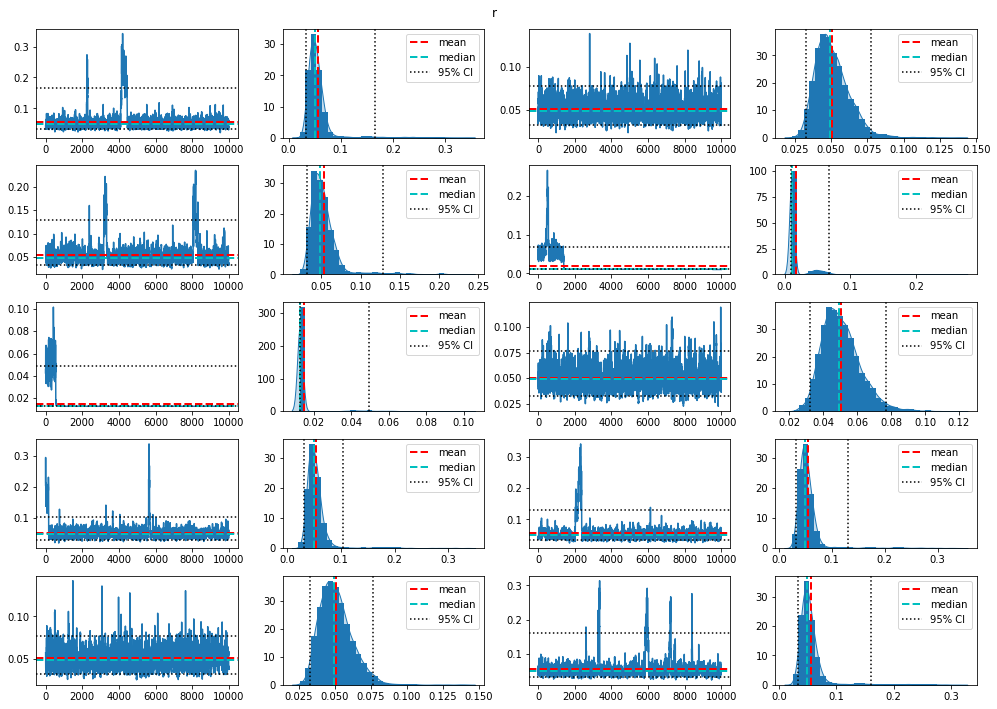

In [59]:
plot_trace(thetas[0], 'r')

100%|██████████| 5/5 [00:01<00:00,  4.06it/s]


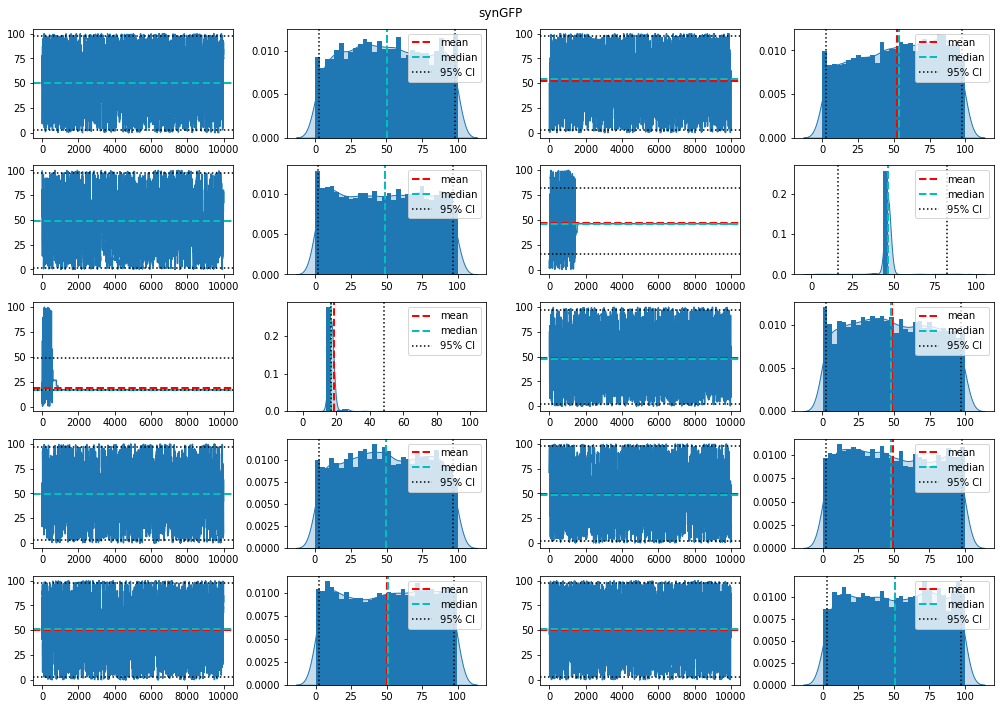

In [60]:
plot_trace(thetas[1], 'synGFP')

In [2]:
thetas[0][0][1999], np.array(loaded['posterior']['y0'])[0][1999], thetas[1][0][1999], 0.02

NameError: name 'thetas' is not defined

### Alternative Model

In [5]:
hill_params = {
    'e11x32STPhoRadA': [8.19215086e+00, 2.77324618e+00, 6.00000000e+00, 1.24643956e+00, 3.56423426e+00, 1.50252702e-10, 3.55907011e+02, 4.95959256e+02],
    'e15x32NpuSspS2': [9.8458614, 8.7957319, 2.89598247, 1.0 , 33.3864939, 26.68735596, 157.80098788, 157.51127152],
    'e16x33NrdA2': [10.13165313, 6.30849837, 5.02963422, 1.26435637, 12.31034403, 5.56520849, 389.61315225, 399.52903402],
    'e20x32gp411': [12.53828935, 1.0, 2.78451886, 1.49241488, 8.42038183, 19.770931, 316.74400613, 314.41729987],
    'e32x30SspGyrB': [10.77387795, 8.56616674, 3.12574014, 1.07032582, 12.42641636, 10.01199595, 353.07383233, 353.36938984],
    'e34x30MjaKlbA': [8.42632247, 13.40974257, 3.28555513, 1.81757507, 8.91852601, 20.20877259, 289.53290172, 287.92030858],
    'e38x32gp418': [7.61231223, 1.51099399, 5.04169259, 1.4068252, 22.75331651, 18.846011, 222.80791219, 223.15092773],
    'e41x32NrdJ1': [9.59574651, 12.05238497, 3.84271899, 1.0, 20.50936546, 14.68953094, 279.98024852, 280.45758993],
    'e42x32STIMPDH1': [10.41225458, 5.87647366, 4.30770405, 1.01184319, 19.08872036, 15.87715881, 232.88219568, 232.90886374]
}

In [3]:
def hill_activation(x, K, n, ymin, ymax):
    
    return ymin + (ymax - ymin) * (x**n / (K**n + x**n))

def hill_activation_and(x, K1, K2, n1, n2, ymin1, ymin2, ymax1, ymax2):
    
    x1, x2 = x
    return hill_activation(x1, K1, n1, ymin1, ymax1) * hill_activation(x2, K2, n2, ymin2, ymax2)

def gate_wrapper(t, r, y0, synGFP, degGFP, x1, x2, params):
    
    K1, K2, n1, n2, ymin1, ymin2, ymax1, ymax2 = params
    ymax = hill_activation_and((x1, x2), K1, K2, n1, n2, ymin1, ymin2, ymax1, ymax2)
    
    def gate_model(y, t):
        y1, GFP = y
        dy1 = r * (1 - (y1/ymax)) * y1
        dGFP = synGFP * y1 - degGFP * GFP
        return [dy1, dGFP]
    
    solution = odeint(gate_model, [y0, 0], t)
    return solution.transpose()

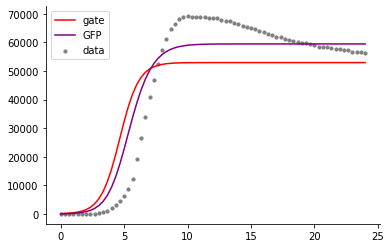

In [13]:
gate = 'e42x32STIMPDH1'
ind1 = 5
ind2 = 5
fluo = fluos['{}_{}{}'.format(gate, ind1, ind2)]
sim = gate_wrapper(fluos.index, 0.022158, 108.175738, 0.022464, 0.02, cumas[ind1], aras[ind2], hill_params[gate])
plt.plot(fluos.index/60, sim[0], color='red', label='gate')
plt.plot(fluos.index/60, sim[1], color='purple', label='GFP')
plt.scatter(fluos.index/60, fluo, color='gray', label='data', s=10)
plt.legend()
sns.despine()

In [ ]:
### STATIC MODELS ###
def hill_equation(x, K, n):
    return x**n / (K**n + x**n)

def growth_rate(t, OD, alpha, beta):
    return (alpha * (1 - (OD/beta)))

### ODE ###

#growth curve
def od_wrapper(t, r, c, c0):

    def od_model(OD, t, r, c):
        dOD = growth_rate(t, OD[0], r, c) * OD[0]
        return dOD
    
    od_sol = odeint(od_model, c0, t, (r, c))
    return np.array(od_sol[:,0])

#model with auto-fluorescence term
def gate_wrapper_complete(t, bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, a, K, n, ind1, ind2, extra, y0):
    
    #fixed parameters
    alpha, beta = extra

    def gate_model(y, t):
        
        #dependent variables
        ECFn, ECFc, ECF, GFP, Auto, OD = y
        
        gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dECFn = bn + syn_ECFn * ind1 - (deg + gamma) * ECFn
        dECFc = bc + syn_ECFc * ind2 - (deg + gamma) * ECFc
        dECF = syn_ECF * ECFn * ECFc - (deg + gamma) * ECF
        
        dGFP = bg + syn_GFP * hill_equation(ECF, K, n) - (deg_GFP + gamma) * GFP
        dAuto = a - gamma * Auto

        return [dECFn, dECFc, dECF, dGFP, dAuto, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

#model with auto-fluorescence term
def gate_wrapper_complete(t, bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, a, K, n, ind1, ind2, extra, y0):
    
    #fixed parameters
    alpha, beta = extra

    def gate_model(y, t):
        
        #dependent variables
        ECFn, ECFc, ECF, GFP, Auto, OD = y
        
        gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dECFn = bn + syn_ECFn * ind1 - (deg + gamma) * ECFn
        dECFc = bc + syn_ECFc * ind2 - (deg + gamma) * ECFc
        dECF = syn_ECF * ECFn * ECFc - (deg + gamma) * ECF
        
        dGFP = bg + syn_GFP * hill_equation(ECF, K, n) - (deg_GFP + gamma) * GFP
        dAuto = a - gamma * Auto

        return [dECFn, dECFc, dECF, dGFP, dAuto, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

#model without auto-fluorescence term
def gate_wrapper(t, bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, K, n, ind1, ind2, extra, y0):
    
    #fixed parameters
    alpha, beta = extra

    def gate_model(y, t):
        
        #dependent variables
        ECFn, ECFc, ECF, GFP, OD = y
        
        gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dECFn = bn + syn_ECFn * ind1 - (deg + gamma) * ECFn
        dECFc = bc + syn_ECFc * ind2 - (deg + gamma) * ECFc
        dECF = syn_ECF * ECFn * ECFc - (deg + gamma) * ECF
        
        dGFP = bg + syn_GFP * hill_equation(ECF, K, n) - (deg_GFP + gamma) * GFP

        return [dECFn, dECFc, dECF, dGFP, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

#model only auto-fluorescence term
def gate_wrapper_auto(t, a, ind1, ind2, extra, y0):
    
    #fixed parameters
    alpha, beta = extra

    def gate_model(y, t):
        
        #dependent variables
        Auto, OD = y
        gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dAuto = a - gamma * Auto
        return [dAuto, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

#model only auto-fluorescence term
def gate_wrapper_gfp(t, syn_GFP, deg_GFP, extra, y0):
    
    def gate_model(y, t):
        
        GFP, OD = y
        alpha, beta = extra
        
        gamma = growth_rate(t, OD, alpha, beta)
        dOD = gamma * OD
        dGFP = syn_GFP - (deg_GFP + gamma) * GFP

        return [dGFP, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

In [ ]:
def simulate_single_state(fluo, f_params, od_params):
    
    num_od_params = 3
    num_vars = 4
    ind1, ind2 = 1, 1
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, (od_params[0], od_params[1]), pd.Series(np.append(np.zeros(num_vars), od_params[2])))
        return pd.Series(fit[3])
    
    return model_fit(fluo.index, *f_params)

In [ ]:
od_params = {
    'e11x32STPhoRadA': [0.0070462352099844, 1.1229375761211622, 0.0973103761235306],
    'e15x32NpuSspS2': [0.0158706098949703, 1.1961969417584624, 0.0235672266874314],
    'e16x33NrdA2': [0.0148194554039306, 1.2408917618889663, 0.0251889022569271],
    'e20x32gp411': [0.0155212086766198, 1.2780552798586051, 0.0193773015388865],
    'e32x30SspGyrB': [0.0159760283755244, 1.150249628464946, 0.0196547733645749],
    'e34x30MjaKlbA': [0.0139910399333654, 1.147632550566836, 0.0235340568336425],
    'e38x32gp418': [0.0155869734557929, 1.2060333912302554, 0.0247131234412902],
    'e41x32NrdJ1': [0.0136188162357974, 1.2375665371324622, 0.0300644005159601],
    'e42x32STIMPDH1': [0.013165608798406, 1.278935730092542, 0.0216016431163906]
}

f_params = {
    'e42x32STIMPDH1': [3.603791540777875, 1.3511898653916996, 39.9998176845689, 6.065998344052423, 
                        3.3384474103706507, 0.4875070387022843, 0.6772492193102161, 0.19905746983366815, 
                        0.013290264735609849, 3.2059353187892787, 2.253921913358458]
}

In [ ]:
fluos = pd.read_csv('datasets/marionette_fluo.csv', index_col='time')
gate = 'e42x32STIMPDH1'
fluo = fluos.loc[:, fluos.columns.str.startswith(gate)].iloc[:,3]

simulated = simulate_single_state(fluo, f_params[gate], od_params[gate])

In [ ]:
plt.plot(fluo.index/60, simulated, color='darkred')
plt.scatter(fluo.index/60, fluo, color='gray', s=10)
plt.title(gate)
sns.despine()

### Animation

In [ ]:
%matplotlib inline
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython import display
plt.rcParams['animation.ffmpeg_path'] = 'utils/ffmpeg'

fig, ax = plt.subplots(figsize=(16, 6))
xdata, ydata = [], []
ln, = plt.plot([], [], 'ro')

def init():
    ax.set_xlim(0, 2*np.pi)
    ax.set_ylim(-1, 1)
    return ln,

def update(frame):
    xdata.append(frame)
    ydata.append(np.sin(frame))
    ln.set_data(xdata, ydata)
    return ln,

anim = FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 128),
                    init_func=init, blit=True)
#video = anim.to_html5_video()
#html = display.HTML(video)
#display.display(html)
#plt.close()
FFwriter = FFMpegWriter()
anim.save('datasets/basic_animation.mp4', writer=FFwriter)

In [ ]:
from matplotlib import animation
from matplotlib.animation import FuncAnimation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)
anim.save('datasets/test.gif', writer='imagemagick')
plt.show()